# **Diamond Price Prediction**

# Brief Description

The dataset for this project contains attributes and prices of around 54,000 diamonds.

**Objectives:**

Perform an Explanatory Data Analysis (EDA).
Create a machine learning model to predict the diamond prices.
Regression models used: Linear, Polynomial, Ridge, Lasso, and CatBoost.

The ten features and target are :

1. Weight (carat): weight of the diamond.
2. Length (x): length of the diamond.
3. Width (y): width of the diamond
4. Depth (z): depth of the diamond.
5. %Depth: depth percentage. Formula: z / mean(x, y) = 2 * z / (x + y)
6. Table: width of top of the diamond relative to the widest point.
7. Quality: quality of the diamond. Possible values (from best to worst): ideal, premium, very good, good, fair.
8. Color: color of the diamond. Possible values: from D (best) to J (worst).
9. Clarity: measurement of how clear the diamond is. Possible values (from best to worst): IF, VVS1, VVS2, VS1, VS2, SI1, SI2, I1.
10. Price (target): price of the diamond in US dollars.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
# Importing Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, ShuffleSplit, KFold, cross_val_predict, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [17]:
import os;
os.listdir('/kaggle/input/')

['diamonds-prices']

In [4]:
df = pd.read_csv('/kaggle/input/diamonds-prices/Diamonds Prices2022.csv', index_col = 0)
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [40]:
# Now, let's check for data type and missing values across the entire dataset:

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53943 entries, 1 to 53943
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53943 non-null  float64
 1   cut      53943 non-null  object 
 2   color    53943 non-null  object 
 3   clarity  53943 non-null  object 
 4   depth    53943 non-null  float64
 5   table    53943 non-null  float64
 6   price    53943 non-null  int64  
 7   x        53943 non-null  float64
 8   y        53943 non-null  float64
 9   z        53943 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.5+ MB


In [5]:
# Let's change the name and order of the columns for easier readability:

# Changing the column names
col_names = {'carat': 'weight',
             'cut': 'quality',
             'depth': '%depth',
             'x': 'length',
             'y': 'width',
             'z': 'depth'}

df.rename(columns = col_names, inplace=True)

# Changing the order of the columns
df = df[['weight', 'length', 'width', 'depth', '%depth', 'table', 'quality', 'color', 'clarity', 'price']]

df.head()

,weight,length,width,depth,%depth,table,quality,color,clarity,price
1,0.23,3.95,3.98,2.43,61.5,55.0,Ideal,E,SI2,326
2,0.21,3.89,3.84,2.31,59.8,61.0,Premium,E,SI1,326
3,0.23,4.05,4.07,2.31,56.9,65.0,Good,E,VS1,327
4,0.29,4.20,4.23,2.63,62.4,58.0,Premium,I,VS2,334
5,0.31,4.34,4.35,2.75,63.3,58.0,Good,J,SI2,335


## Data Cleaning

In [6]:
df.isnull().sum()  

# Fortunately, there are not missing values.

weight     0
length     0
width      0
depth      0
%depth     0
table      0
quality    0
color      0
clarity    0
price      0
dtype: int64

In [7]:
duplicates = df[df.duplicated()].reset_index()
duplicates

# There are 149 duplicate values

,index,weight,length,width,depth,%depth,table,quality,color,clarity,price
0,1006,0.79,5.90,5.85,3.66,62.3,57.0,Ideal,G,SI1,2898
1,1007,0.79,5.90,5.85,3.66,62.3,57.0,Ideal,G,SI1,2898
2,1008,0.79,5.90,5.85,3.66,62.3,57.0,Ideal,G,SI1,2898
3,1009,0.79,5.90,5.85,3.66,62.3,57.0,Ideal,G,SI1,2898
4,2026,1.52,7.53,7.42,4.28,57.3,58.0,Good,E,I1,3105
...,...,...,...,...,...,...,...,...,...,...,...
144,50080,0.51,5.19,5.17,3.17,61.2,56.0,Ideal,F,VVS2,2203
145,52862,0.50,5.21,5.18,4.09,79.0,73.0,Fair,E,VS2,2579
146,53941,0.71,5.79,5.74,3.49,60.5,55.0,Premium,E,SI1,2756
147,53942,0.71,5.74,5.73,3.43,59.8,62.0,Premium,F,SI1,2756


In [8]:
# All duplicates are removed

df.drop_duplicates(inplace = True)

In [9]:
df.reset_index(inplace = True)

In [10]:
df.drop(["index"], axis = 1, inplace = True)

In [11]:
df.head()

,weight,length,width,depth,%depth,table,quality,color,clarity,price
0,0.23,3.95,3.98,2.43,61.5,55.0,Ideal,E,SI2,326
1,0.21,3.89,3.84,2.31,59.8,61.0,Premium,E,SI1,326
2,0.23,4.05,4.07,2.31,56.9,65.0,Good,E,VS1,327
3,0.29,4.20,4.23,2.63,62.4,58.0,Premium,I,VS2,334
4,0.31,4.34,4.35,2.75,63.3,58.0,Good,J,SI2,335


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53794 entries, 0 to 53793
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   weight   53794 non-null  float64
 1   length   53794 non-null  float64
 2   width    53794 non-null  float64
 3   depth    53794 non-null  float64
 4   %depth   53794 non-null  float64
 5   table    53794 non-null  float64
 6   quality  53794 non-null  object 
 7   color    53794 non-null  object 
 8   clarity  53794 non-null  object 
 9   price    53794 non-null  int64  
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


In [13]:
df.describe()

,weight,length,width,depth,%depth,table,price
count,53794.00000,53794.000000,53794.000000,53794.000000,53794.000000,53794.000000,53794.000000
mean,0.79778,5.731214,5.734653,3.538714,61.748080,57.458109,3933.065082
std,0.47339,1.120695,1.141209,0.705037,1.429909,2.233679,3988.114460
min,0.20000,0.000000,0.000000,0.000000,43.000000,43.000000,326.000000
25%,0.40000,4.710000,4.720000,2.910000,61.000000,56.000000,951.000000
50%,0.70000,5.700000,5.710000,3.530000,61.800000,57.000000,2401.000000
75%,1.04000,6.540000,6.540000,4.030000,62.500000,59.000000,5326.750000
max,5.01000,10.740000,58.900000,31.800000,79.000000,95.000000,18823.000000


In [14]:
# 'quality', 'color', and 'clarity' are categorical variables. Let's see their possible values:

print(df['quality'].value_counts(normalize=True))     #--> 5 Categorical Values, "Ideal" being used highest
print('===================')
print(df['color'].value_counts(normalize=True))       #--> 7 Categroical Values, "G" being used highest
print('===================')
print(df['clarity'].value_counts(normalize=True))     #--> 8 Categorical Values, "SI1"being used highest

Ideal        0.399450
Premium      0.255568
Very Good    0.224356
Good         0.090921
Fair         0.029706
Name: quality, dtype: float64
G    0.209354
E    0.181730
F    0.176971
H    0.153772
D    0.125572
I    0.100513
J    0.052088
Name: color, dtype: float64
SI1     0.242258
VS2     0.227330
SI2     0.170093
VS1     0.151615
VVS2    0.093988
VVS1    0.067796
IF      0.033164
I1      0.013756
Name: clarity, dtype: float64


**Quick insights:**

- There are 53,794 instances and no missing values.
- The features (quality, color, and clarity) are categorical and need to be enconded.
- Taking a quick look at the statistical table (df.describe()), we see that some features and the price target might have some outliers. For instance, the mean 'width' is 5.73. However, the maximum value found in the dataset is 58.9. Therefore, we need to check the distribution and possibly some boxplots.

## Explanatory Data Analysis (EDA)

### Price wrt numeric features

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


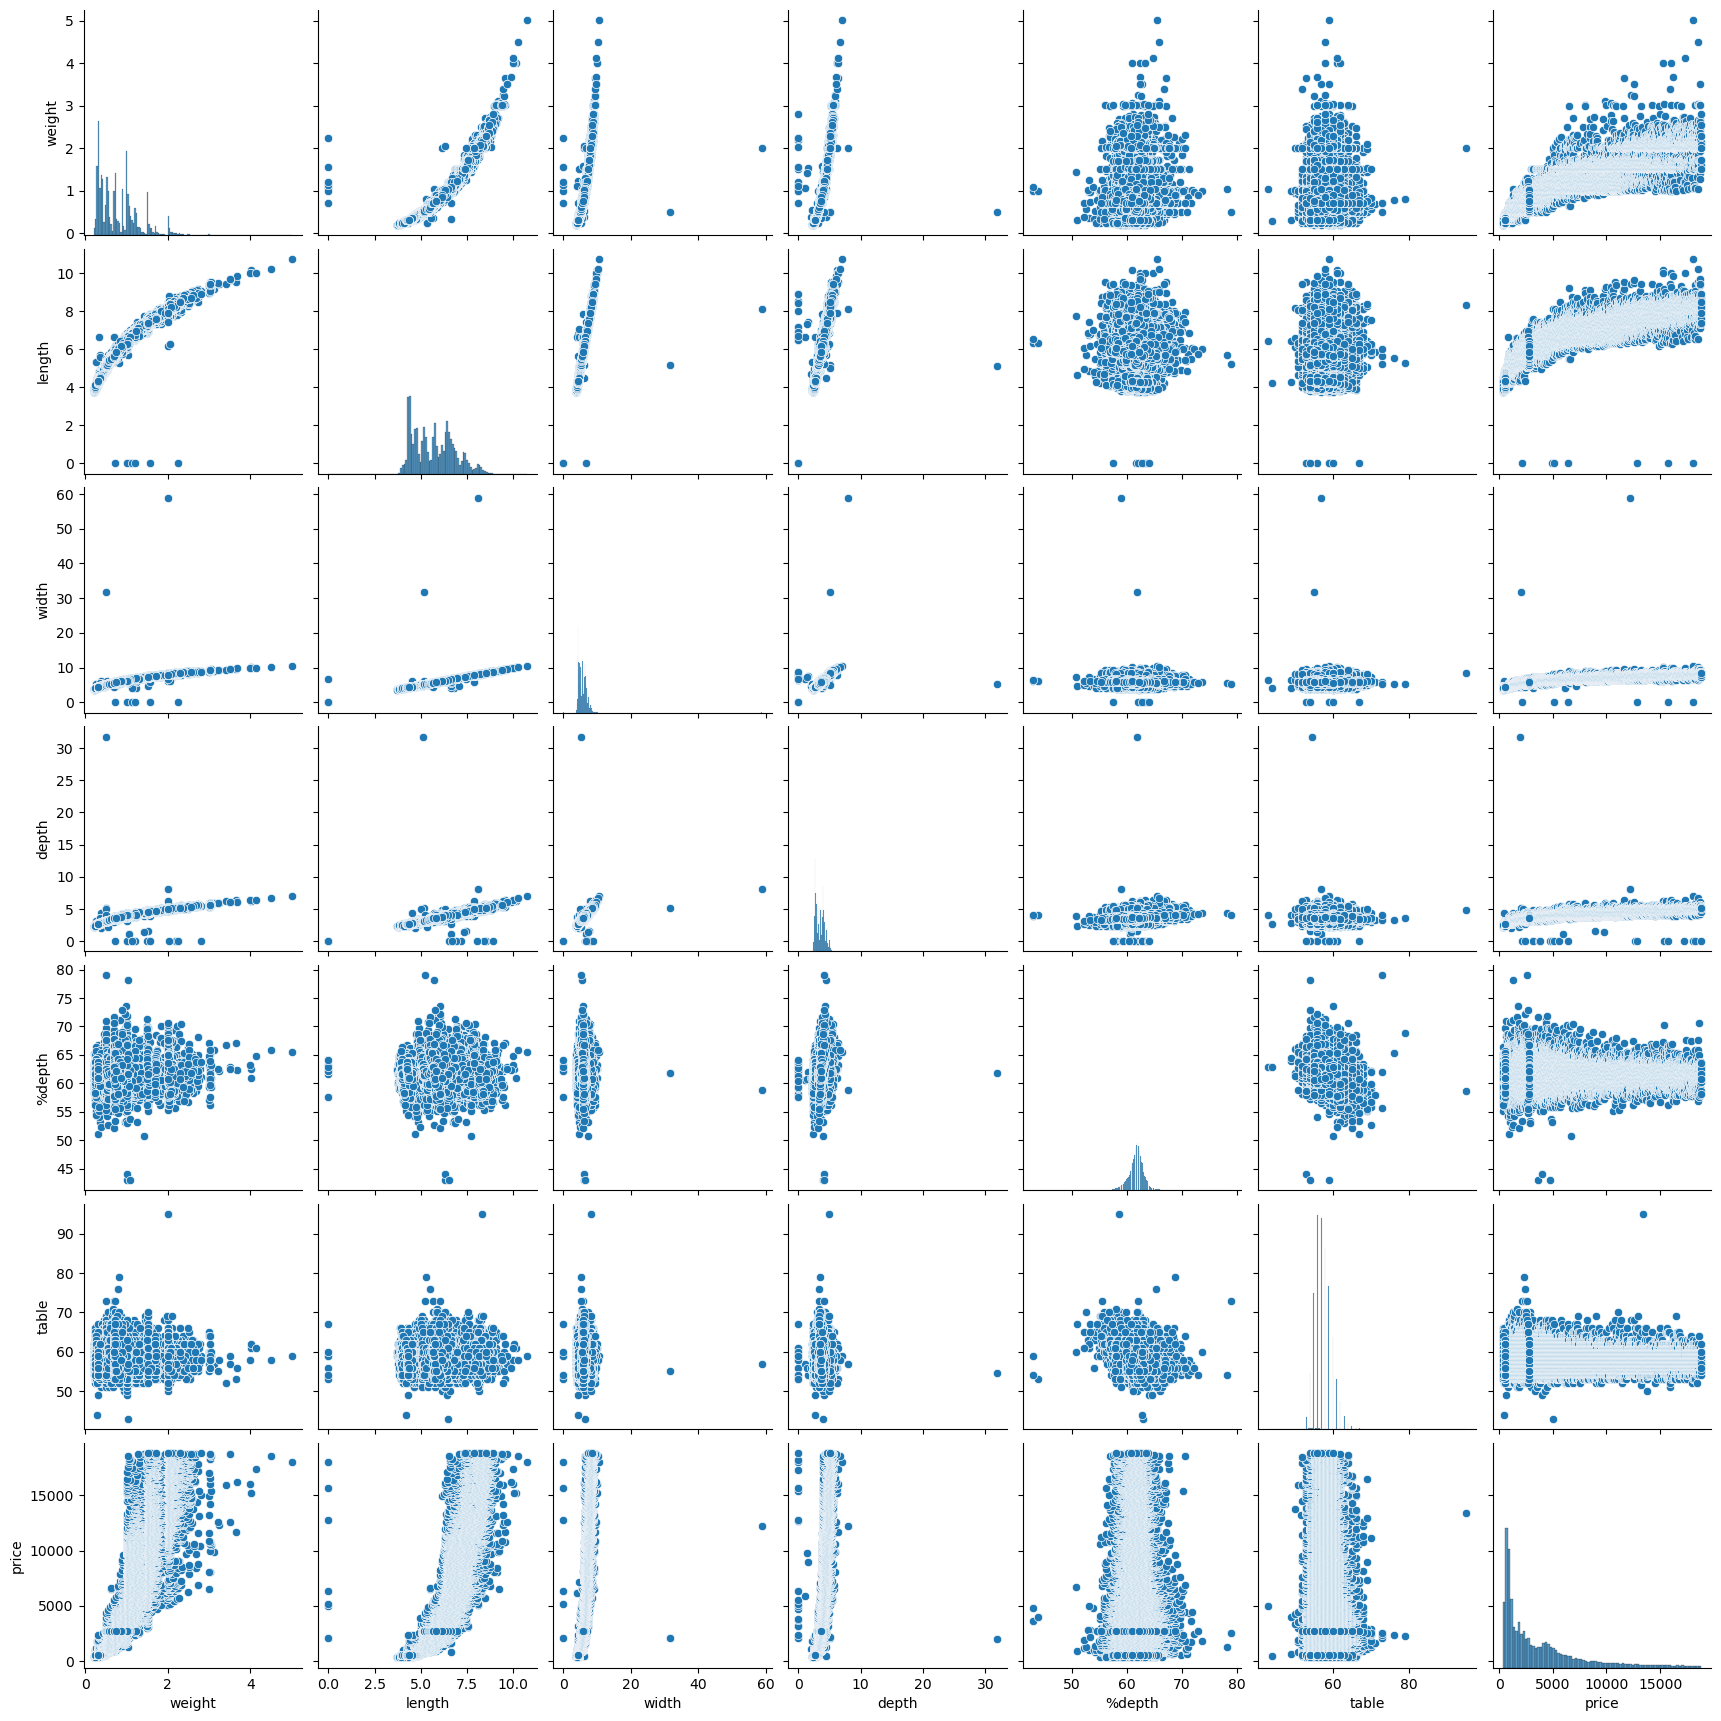

In [62]:
# Method 1

sns.pairplot(df)

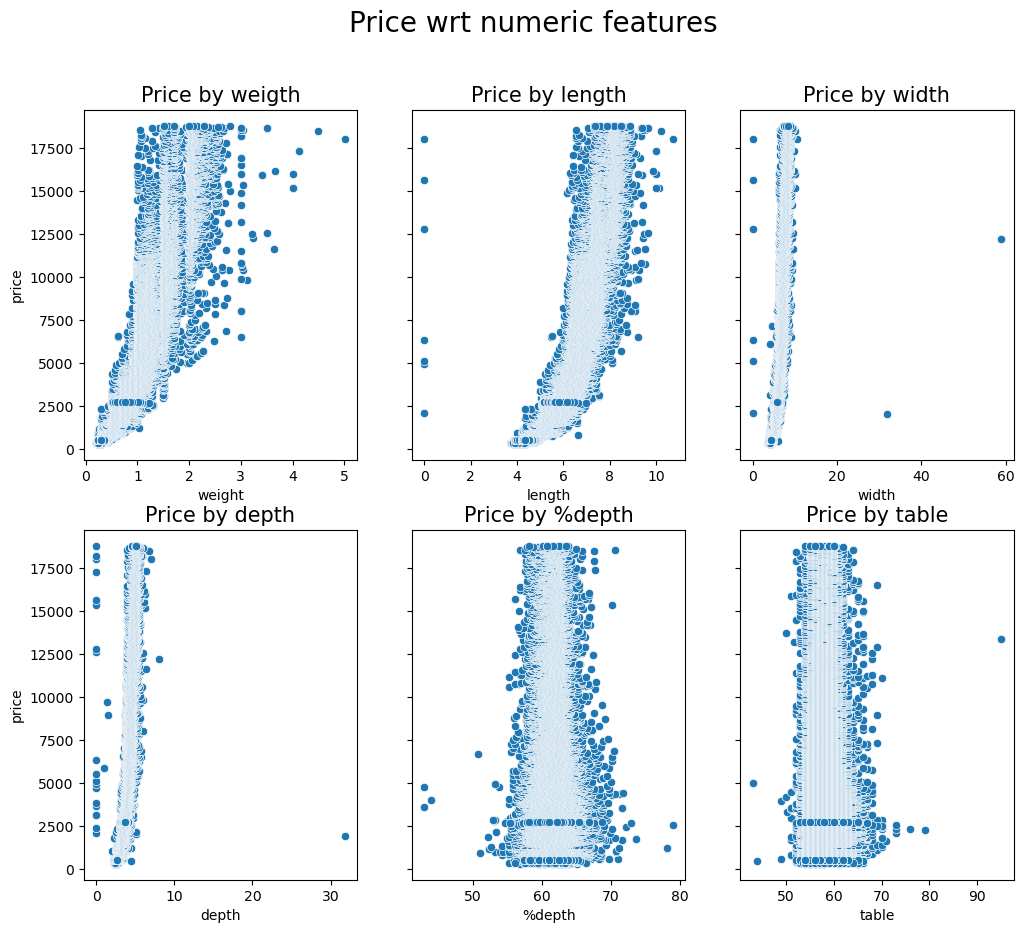

In [63]:
# Method 2

fig, axes = plt.subplots(2, 3, figsize=(12, 10), sharey=True)  # sharey => mean we are sharing the y-axis with all subplots
fig.suptitle('Price wrt numeric features', fontsize=20)
plt.rcParams['axes.titlesize'] = 15

sns.scatterplot(x = "weight", y = "price", data=df, ax=axes[0,0])
axes[0,0].set_title('Price by weigth')
sns.scatterplot(x = "length", y = "price", data=df, ax=axes[0,1])
axes[0,1].set_title('Price by length')
sns.scatterplot(x = "width", y = "price", data=df, ax=axes[0,2])
axes[0,2].set_title('Price by width')
sns.scatterplot(x = "depth", y = "price", data=df, ax=axes[1,0])
axes[1,0].set_title('Price by depth')
sns.scatterplot(x = "%depth", y = "price", data=df, ax=axes[1,1])
axes[1,1].set_title('Price by %depth')
sns.scatterplot(x = "table", y = "price", data=df, ax=axes[1,2])
axes[1,2].set_title('Price by table')
plt.show()

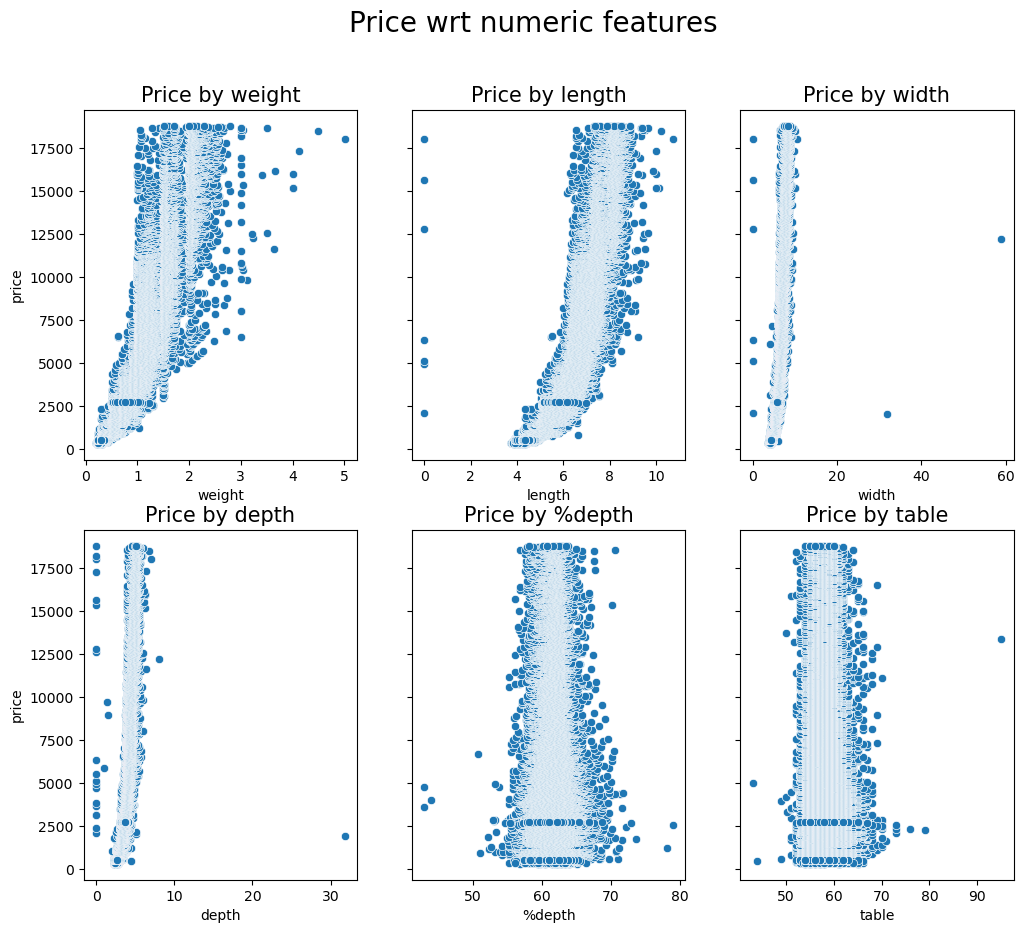

In [64]:
# Method 3

fig, axes = plt.subplots(2, 3, figsize=(12, 10), sharey=True)  # sharey => means we are sharing the y-axis with all subplots
fig.suptitle('Price wrt numeric features', fontsize=20)
plt.rcParams['axes.titlesize'] = 15

numeric_features = ["weight", "length", "width", "depth", "%depth", "table"]
titles = ["Price by weight", "Price by length", "Price by width", "Price by depth", "Price by %depth", "Price by table"]

for i, feature in enumerate(numeric_features):
    sns.scatterplot(x=feature, y="price", data=df, ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(titles[i])

plt.show()

**Insights:**

- Weight, length, width, and depth seem to have a higher correlation with price (will check with heatmap)
- There is no evident correlation between price and both %depth and table.
- There seem to be some outliers, especially in width and depth, as well as %depth and price.

Let's plot a correlation heatmap to dig in a bit deeper:

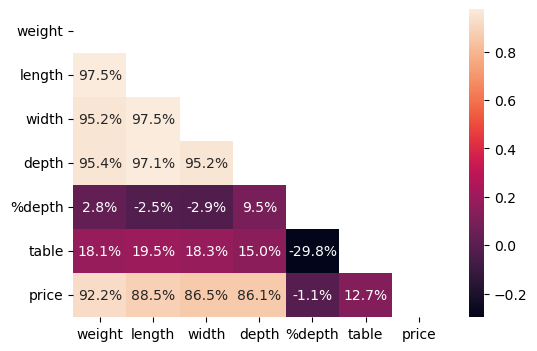

In [65]:
# Correlation Heatmap

plt.figure(figsize = (6,4))
mask = np.triu(np.ones_like(df.corr(numeric_only = True )))
sns.heatmap(data = df.corr(numeric_only= True), mask = mask, fmt = ".1%", annot = True)
plt.show()

**Insight:**

- As expected, high correlation between the sizes of the diamonds and their price.
- Lower correlation between table and price.
- Almost no correlation between %depth and price. We might want to remove this feature to build the ML models.
- Correllation between numeric features and price are positve. Meaning that the higher the size of the diamond, the more costly it is, which actually makes sense.

### Dealing with outliers

Now, coming back to the outliers, let's plot some boxplots:

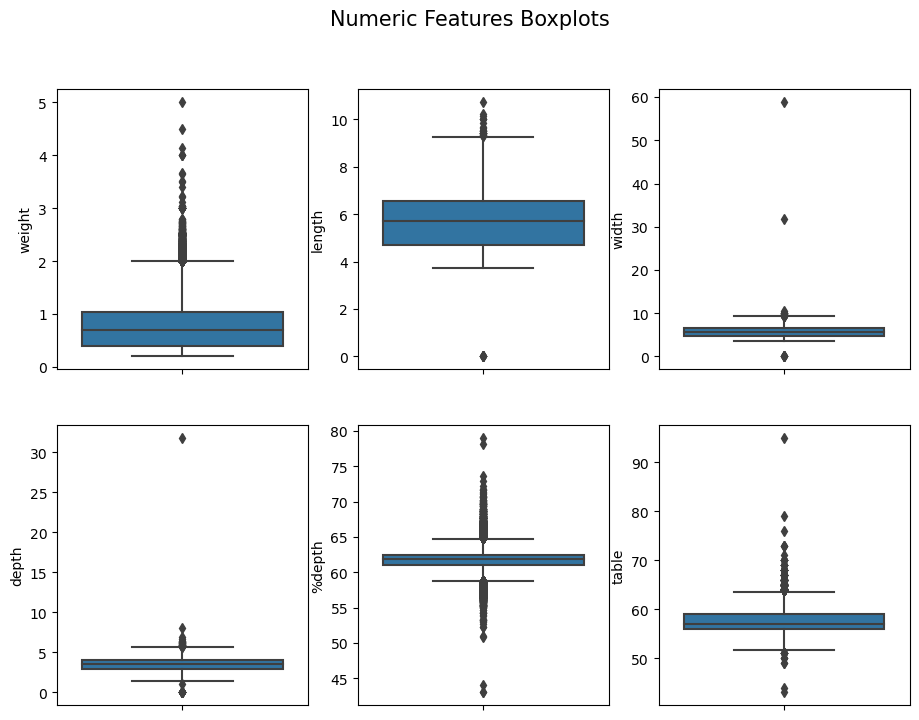

In [66]:
# Method 1 

fig, axes = plt.subplots(2, 3, figsize=(11, 8)) 
fig.suptitle('Numeric Features Boxplots', fontsize= 15)

sns.boxplot(y = "weight", data=df, ax=axes[0,0])
sns.boxplot(y = "length", data=df, ax=axes[0,1])
sns.boxplot(y = "width", data=df, ax=axes[0,2])
sns.boxplot(y = "depth", data=df, ax=axes[1,0])
sns.boxplot(y = "%depth", data=df, ax=axes[1,1])
sns.boxplot(y = "table", data=df, ax=axes[1,2])
plt.show()

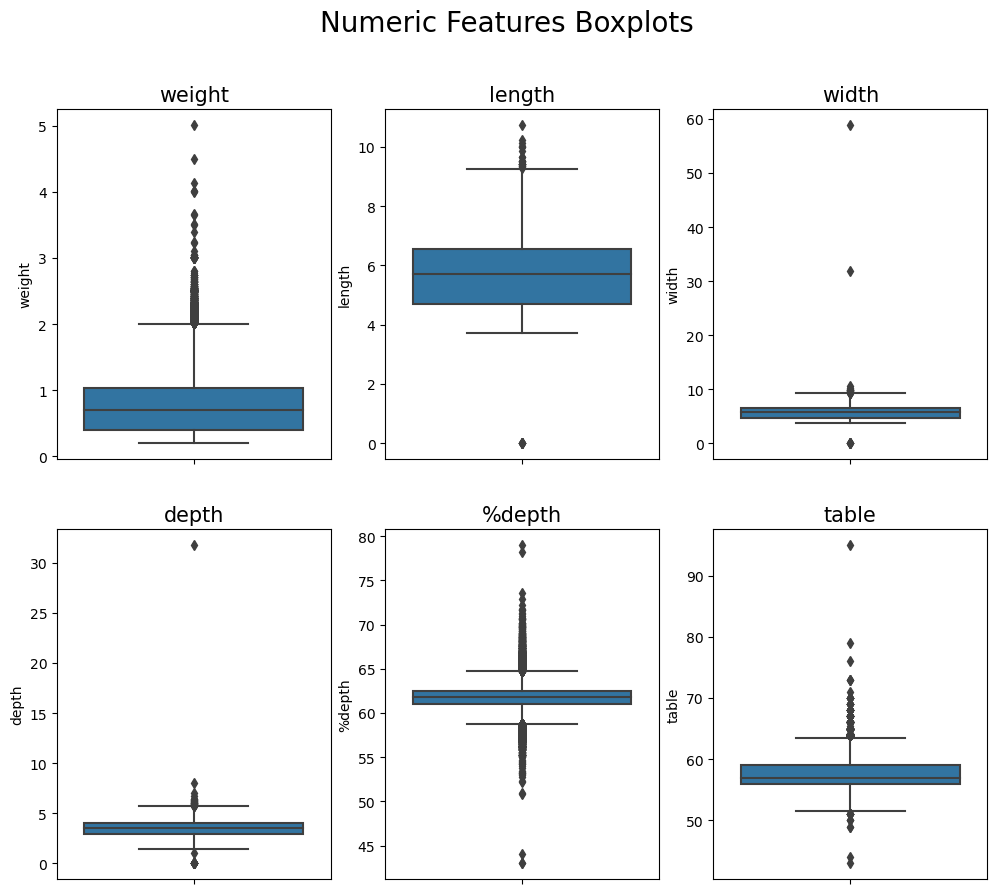

In [76]:
# Method 2

fig, axes = plt.subplots(2, 3, figsize=(12, 10)) 
fig.suptitle('Numeric Features Boxplots', fontsize=20)
plt.rcParams['axes.titlesize'] = 15

num_attributes = df.select_dtypes(exclude='object')       # or you can directly give the list
num_attributes.drop("price", axis =1, inplace= True)
numerical_features = num_attributes.columns.tolist()

titles = numeric_features.copy()

for i, feature in enumerate(numerical_features):
    sns.boxplot(y= feature, data=df, ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(titles[i])

plt.show()

**Insight:**

- There is definitely a presence of outliers. Since the dataset is large enough (more than 53,000 instances), I decided to remove some of these values so that the ML models generalize better.

To handle these outliers, I set mininium and maximum values for each feature looking at the scatter plots shown above.

- Length: remove values below 2.
- Width: remove values above 20.
- Depth: remove values equal to zero, and values over 15.
- Table: remove values over 90.

In [15]:
# DROP OUTLIERS

outliers = []
# Outliers in length
entries = df[df['length']<2].index  # There are 8 entries with lenth zero, we are going to delete those observations.
outliers.extend(entries)

# Outliers in width
entries = df[df['width']>20].index
outliers.extend(entries)

# Outliers in depth
entries = df[(df['depth'] == 0) | (df['depth']>15)].index
outliers.extend(entries)

# Outliers in table
entries = df[df['table'] > 90].index
outliers.extend(entries)

# Drop ouliers altogether
df.drop(outliers, axis=0, inplace=True)

# Check how many outliers were removed
print(f'Outliers removed: {len(outliers)}')

Outliers removed: 30


Let's replot the price with respect to the numeric features and see the difference:

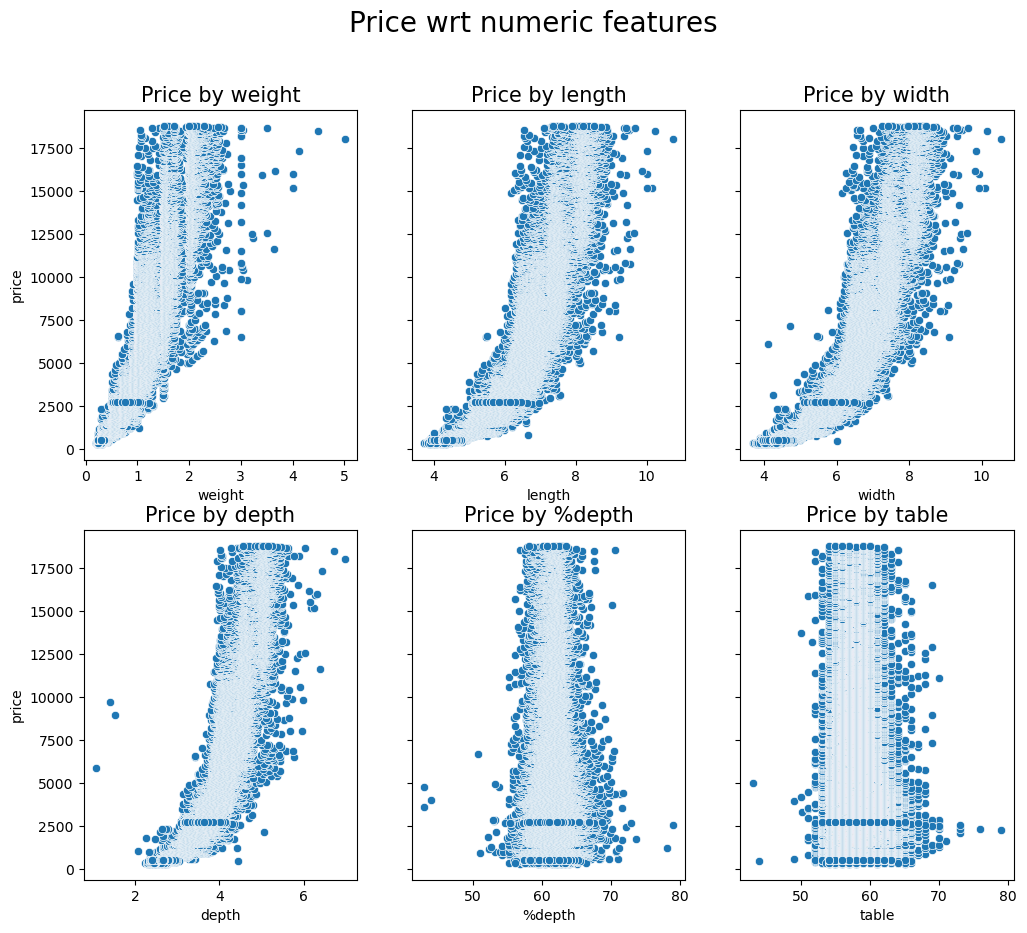

In [79]:
fig, axes = plt.subplots(2, 3, figsize=(12, 10), sharey=True)  # sharey => means we are sharing the y-axis with all subplots
fig.suptitle('Price wrt numeric features', fontsize=20)
plt.rcParams['axes.titlesize'] = 15

numeric_features = ["weight", "length", "width", "depth", "%depth", "table"]
titles = ["Price by weight", "Price by length", "Price by width", "Price by depth", "Price by %depth", "Price by table"]

for i, feature in enumerate(numeric_features):
    sns.scatterplot(x=feature, y="price", data=df, ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(titles[i])

plt.show()

**Insight:**

- The plots look much better. The model will definitely generalize better.
- Important: only 30 instances were removed, which accounts for only 0.056% of the data.

### Prices by weight and different qualities

Weight is the most correlated feature to price. Then, let's check how price behaves with respect to weight with different diamond qualities:

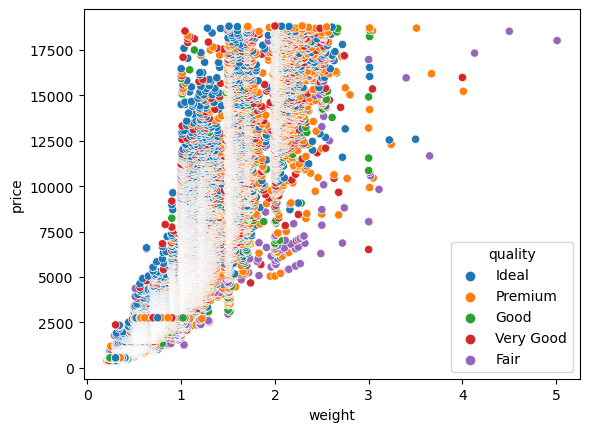

In [88]:
sns.scatterplot(x = "weight", y = "price", hue = "quality", data=df)
plt.show()

**Insight:**

- Overall, we can see that for the same value of weight, the price of the diamonds are higher for better qualities.
- Such insight makes sense since between two diamonds of the same weight, the one with better quality should be more expensive.
- However, it is not that straightforward as other variables such 'color', 'clarity' and even the 'sizes' are also taken into account on the diamond's price.

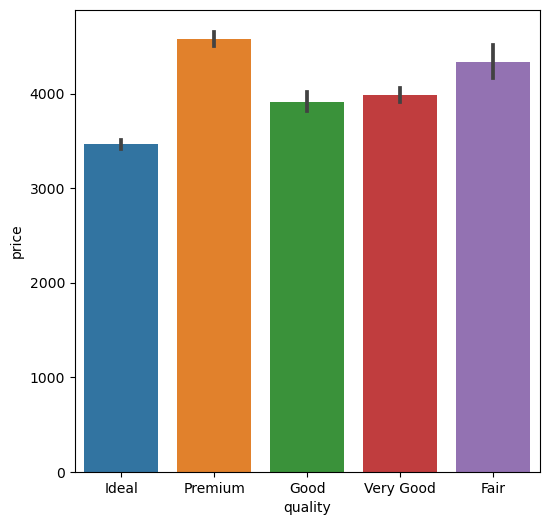

In [87]:
plt.figure(figsize = (6,6))
sns.barplot(data = df, x = "quality", y = "price")
plt.show()

# Note that this doesnot tell us about price of a diamond, it only tells that in the provided data Premium diamond has contributed the most in revenue generation on an average.
# That is it tells you about Mean Price of Diamond for different qualities in the dataset which can be due to the reason that some diamonds were sold more than the other.

### Prices by weight and different clarities

In [89]:
# Interactive Plot by plotly

colors = ['#4F3EBC', '#CA4CB7', '#2B8639', '#A0C173', '#DA933F', '#D7E33E', '#D13F33', '#51524B']

fig = px.scatter(df, x='weight', y='price', color='clarity', width=1000, height=500, 
                 color_discrete_sequence = colors,
                 category_orders = {'clarity':['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']},   # IF is best 
                 title="Price by weight and clarity")
fig.update_layout(
    xaxis_title="Weight",
    yaxis_title="Price")
fig.show()

**Insight:**

The better clarity (being IF the best), the more expensive the diamond is.

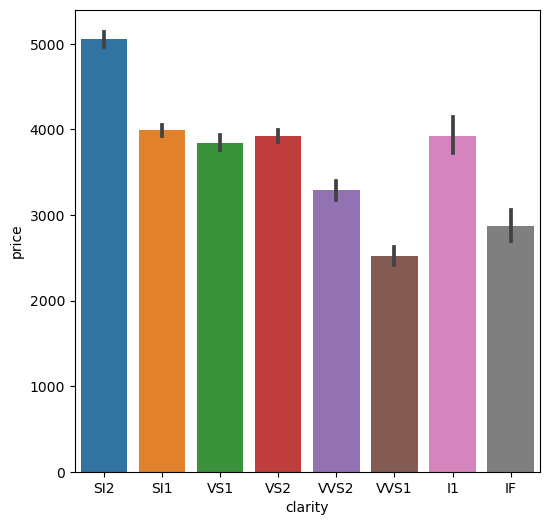

In [90]:
# To see mean price of sold diamonds, clarity wise

# Method 1 - Visualization

%matplotlib inline
plt.figure(figsize = (6,6))
sns.barplot(data = df, x = "clarity", y = "price")
plt.show()

# This graph shows that most contributin diamond in terms of total revenue is of clarity SI2 (which is not a good clarity diamond). 
# Note that this doesnot tell us about price of a diamond, it only tells in the provided data SI2 diamond has contributed the highest.
# The barplot in Seaborn by default shows the mean value of the 'y' variable (price) for each category of the 'x' variable (clarity). 
# It calculates the mean price for each unique value of the 'clarity' column and displays it as the height of the bar.
# If you want to show a different summary statistic, such as median or sum, you can use the estimator parameter of the barplot function.

In [91]:
# Method 2 - Direct

df.groupby("clarity")["price"].mean().sort_values(ascending = False)  

clarity
SI2     5053.746308
SI1     3993.550925
I1      3927.303935
VS2     3925.614806
VS1     3841.746106
VVS2    3286.532437
IF      2870.569507
VVS1    2522.993692
Name: price, dtype: float64

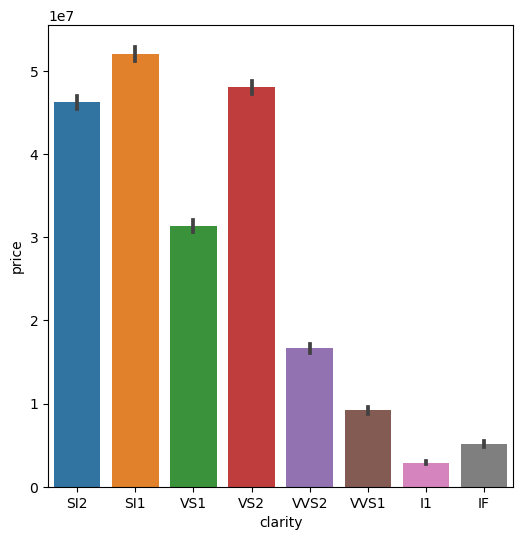

In [92]:
# To see Total price of sold diamonds, clarity wise

# Mehtod 1 - Visualization

%matplotlib inline
plt.figure(figsize = (6,6))
sns.barplot(data = df, x = "clarity", y = "price", estimator = sum)
plt.show()

In [93]:
# Method 2 - Direct

df.groupby("clarity")["price"].sum().sort_values(ascending = False)

clarity
SI1     52031975
VS2     47990641
SI2     46196295
VS1     31321756
VVS2    16616708
VVS1     9198835
IF       5121096
I1       2894423
Name: price, dtype: int64

In [94]:
df["clarity"].value_counts()

SI1     13029
VS2     12225
SI2      9141
VS1      8153
VVS2     5056
VVS1     3646
IF       1784
I1        737
Name: clarity, dtype: int64

### Prices by weight and different colors

In [95]:
# Interactive plot using plotly

colors = ['#4F3EBC', '#CA4CB7', '#2B8639', '#A0C173', '#DA933F', '#D7E33E', '#D13F33']

fig = px.scatter(df, x='weight', y='price', color='color', width=1000, height=500, 
                 color_discrete_sequence=colors,
                 title="Price by weight and color")
fig.update_layout(
    xaxis_title="Weight",
    yaxis_title="Price")
fig.show()

**Insight:**

The better color (being D the best), the more costly the diamond is.

### Distribution

Let's check the distribution and skewness of the target and features:

As we will be building a Linear Regression plot thus its fourth condition is that the variables should be normally distributed

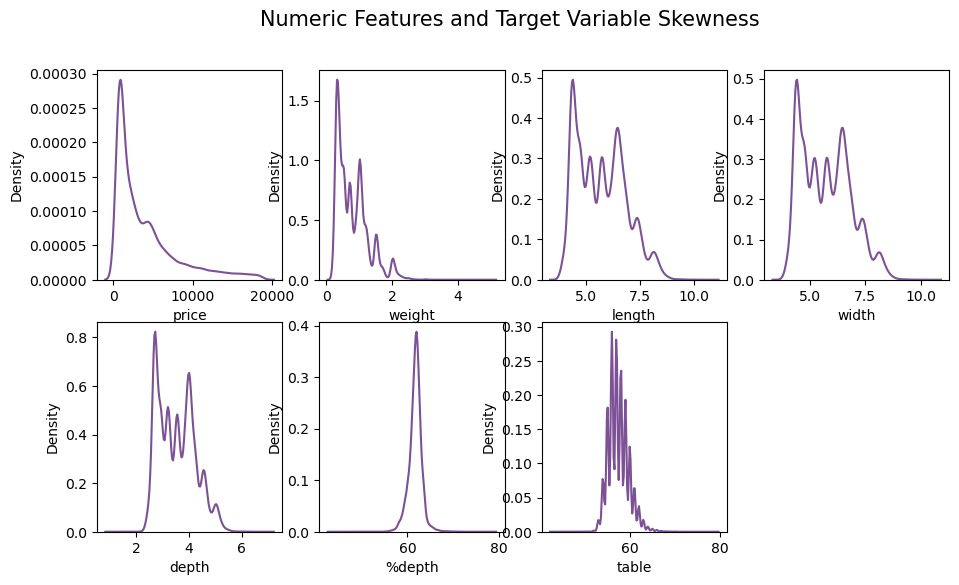

In [96]:
fig, axes = plt.subplots(2, 4, figsize=(11, 6)) 
fig.suptitle('Numeric Features and Target Variable Skewness', fontsize= 15)

sns.kdeplot(x = "price", data=df, ax=axes[0,0], color='#7C5195' )
sns.kdeplot(x = "weight", data=df, ax=axes[0,1], color='#7C5195')
sns.kdeplot(x = "length", data=df, ax=axes[0,2], color='#7C5195' )
sns.kdeplot(x = "width", data=df, ax=axes[0,3], color='#7C5195' )
sns.kdeplot(x = "depth", data=df, ax=axes[1,0], color='#7C5195' )
sns.kdeplot(x = "%depth", data=df, ax=axes[1,1], color='#7C5195' )
sns.kdeplot(x = "table", data=df, ax=axes[1,2], color='#7C5195' )

# Remove the empty subplot
fig.delaxes(axes[1, 3])

plt.show()

In [16]:
df.skew(numeric_only = True)

weight    1.113211
length    0.396796
width     0.391283
depth     0.391687
%depth   -0.113619
table     0.710194
price     1.618414
dtype: float64

**Insigths:**

All varaibles are positive skewed except %depth (however we have previously decided not to consider it in the model as it doesnot follow the first assumption of linear model that is linear relationship with target variable). If possible, we need to get those values closer to zero.

- Weight, table and price are more positively skewed. Table is also not considered as it also violates first assumption for linear model.
- Length, width, depth can be considered as normally distiributed however we can try to get them close to 0 as much as possible

### Applying log and boxcox transformations

Different types of transformations were applied to each variable.

The best performers were boxcox for price and weight, and logarithmic transformation for the rest.

In [17]:
data = df.copy()

In [18]:
data.head()

,weight,length,width,depth,%depth,table,quality,color,clarity,price
0,0.23,3.95,3.98,2.43,61.5,55.0,Ideal,E,SI2,326
1,0.21,3.89,3.84,2.31,59.8,61.0,Premium,E,SI1,326
2,0.23,4.05,4.07,2.31,56.9,65.0,Good,E,VS1,327
3,0.29,4.20,4.23,2.63,62.4,58.0,Premium,I,VS2,334
4,0.31,4.34,4.35,2.75,63.3,58.0,Good,J,SI2,335


### Boxcox Transformation
- It is one of the method to tranform the variables having some skewness into normal distribution so that we can apply the Linear Regression model.

- In our case, data["price_cox"] is the transformed column where the Box-Cox transformation results will be stored. The lambda_val variable will contain the estimated lambda parameter used in the transformation.

- Note that the Box-Cox transformation assumes that the input data is positive. If the "price" column contains zero or negative values, you may need to add a constant value to make all values positive before applying the transformation.

**Example:** data["price_cox"], lambda_val = stats.boxcox(data["price"] + constant_value)

Replace constant_value with a positive constant, such as 1, to ensure all values are positive before applying the Box-Cox transformation.

- lamda_val represents the estimated lambda parameter. The lambda parameter determines the type of transformation applied to the data. Depending on the value of lambda, different transformations are performed. Here are a few common scenarios:
1. If lambda is 0, a logarithmic transformation is applied (log(x)).
2. If lambda is 1, no transformation is applied (x).
3. If lambda is -1, an inverse transformation is applied (1/x).
4. For other non-zero lambda values, a power transformation is applied ((x^lambda - 1)/lambda).

- The lambda_val returned by the boxcox function indicates the estimated lambda parameter that optimizes the transformation for the given data. It is important to note that the lambda parameter is estimated based on the data itself, so the actual value of lambda can vary depending on the dataset.

- The lambda_val can be used later for inverse transformations if needed. To inverse transform the data after applying the Box-Cox transformation, you can use the scipy.special.inv_boxcox function, passing the lambda parameter as an argument.

**Example:**

import scipy.special as special

data["price_inverse"] = special.inv_boxcox(data["price_cox"], lambda_val)

- This will apply the inverse Box-Cox transformation to the "price_cox" column using the lambda parameter stored in lambda_val, resulting in the "price_inverse" column with the original values.

In [19]:
# Boxcox Tranformation on Price

from scipy import stats

data["price_cox"], lambda_val = stats.boxcox(data["price"])

In [20]:
lambda_val

-0.06652058610860367

In [21]:
# Boxcox Tranformation on Weight

data["weight_cox"], lambda_val = stats.boxcox(data["weight"])

In [22]:
lambda_val

-0.09337605296907327

In [23]:
data.head()

,weight,length,width,depth,%depth,table,quality,color,clarity,price,price_cox,weight_cox
0,0.23,3.95,3.98,2.43,61.5,55.0,Ideal,E,SI2,326,4.803233,-1.575295
1,0.21,3.89,3.84,2.31,59.8,61.0,Premium,E,SI1,326,4.803233,-1.680093
2,0.23,4.05,4.07,2.31,56.9,65.0,Good,E,VS1,327,4.805317,-1.575295
3,0.29,4.20,4.23,2.63,62.4,58.0,Premium,I,VS2,334,4.819717,-1.312254
4,0.31,4.34,4.35,2.75,63.3,58.0,Good,J,SI2,335,4.821748,-1.237623


## Data Preprocessing

In [24]:
# We will start with removing the unwanted columns 

data.drop(columns = ["weight", "price", "%depth", "table"] ,axis=1, inplace = True)

In [25]:
# Changing the column names

col_names = {'price_cox': 'price',
             'weight_cox': 'weight'}

data.rename(columns=col_names, inplace=True)

In [26]:
# Changing the order of the columns

data = data[['weight', 'length', 'width', 'depth', 'quality', 'color', 'clarity', 'price']]
data.head()

,weight,length,width,depth,quality,color,clarity,price
0,-1.575295,3.95,3.98,2.43,Ideal,E,SI2,4.803233
1,-1.680093,3.89,3.84,2.31,Premium,E,SI1,4.803233
2,-1.575295,4.05,4.07,2.31,Good,E,VS1,4.805317
3,-1.312254,4.20,4.23,2.63,Premium,I,VS2,4.819717
4,-1.237623,4.34,4.35,2.75,Good,J,SI2,4.821748


In [27]:
data.describe()

,weight,length,width,depth,price
count,53771.000000,53771.000000,53771.000000,53771.000000,53771.000000
mean,-0.419092,5.731509,5.733398,3.539300,6.057095
std,0.605532,1.118544,1.110455,0.691051,0.603084
min,-1.736666,3.730000,3.680000,1.070000,4.803233
25%,-0.956632,4.710000,4.720000,2.910000,5.506435
50%,-0.362681,5.700000,5.710000,3.530000,6.075617
75%,0.039149,6.540000,6.540000,4.030000,6.537764
max,1.496059,10.740000,10.540000,6.980000,7.222255


### logarithmic Transformation

- np.log() computes the natural logarithm (base e) or "ln" of the value

Applying log transformation on length, width, depth variables

- Make sure the features you want to transform are numerical and have no zero or negative values, as the natural logarithm is only defined for positive values.

In NumPy, the functions `np.log()` and `np.log1p()` are both used for logarithmic transformations, but they have different purposes and usage scenarios.

1. **`np.log(x):`**

- The np.log() function computes the natural logarithm (base e) of each element in the input array x.
- It returns the logarithm values of the positive elements in x.
- The np.log() function is suitable when you want to perform a logarithmic transformation on data that contains only positive values.
- Note that if x contains zero or negative values, np.log() will produce NaN (Not a Number) or complex values.

2. **`np.log1p(x):`**

- The np.log1p() function computes the natural logarithm of 1 + x for each element in the input array x.
- It is designed to handle input values that are close to zero more effectively than np.log().
- np.log1p() is useful when you want to perform a logarithmic transformation on data that may contain zero or small positive values.
- By adding 1 to the input values before applying the logarithm, it avoids the issues of NaN or complex results that can occur with np.log() when the input is close to zero.
- The np.log1p() function is numerically stable for small values of x, ensuring accurate transformations.

In summary, if your data may contain zero or small positive values, it is generally recommended to use np.log1p() to avoid potential errors or numerical instability. However, if you are confident that your data only contains positive values and does not include zeros, np.log() can be used as well.

In [28]:
for feature in data.columns[1:4]:
    data[feature] = np.log(data[feature])     # we have used np.log(), however np.log1p() would be more correct as values are close to 0. However we have checked there is no 0 or negative values.

In [29]:
data.head()

,weight,length,width,depth,quality,color,clarity,price
0,-1.575295,1.373716,1.381282,0.887891,Ideal,E,SI2,4.803233
1,-1.680093,1.358409,1.345472,0.837248,Premium,E,SI1,4.803233
2,-1.575295,1.398717,1.403643,0.837248,Good,E,VS1,4.805317
3,-1.312254,1.435085,1.442202,0.966984,Premium,I,VS2,4.819717
4,-1.237623,1.467874,1.470176,1.011601,Good,J,SI2,4.821748


Now, as we have done with the Transformation, let's check the distribution again

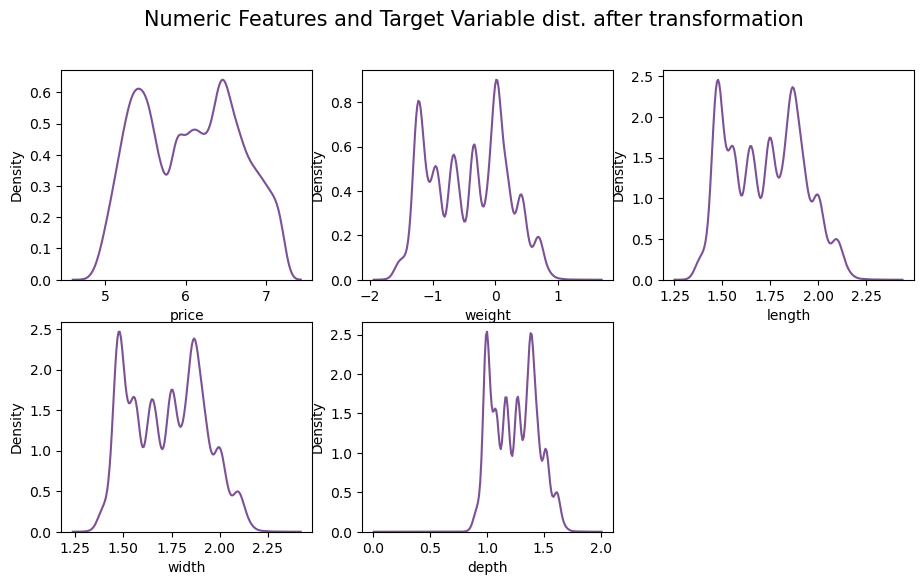

In [112]:
fig, axes = plt.subplots(2, 3, figsize=(11, 6)) 
fig.suptitle('Numeric Features and Target Variable dist. after transformation', fontsize= 15)

sns.kdeplot(x = "price", data=data, ax=axes[0,0], color='#7C5195' )
sns.kdeplot(x = "weight", data=data, ax=axes[0,1], color='#7C5195')
sns.kdeplot(x = "length", data=data, ax=axes[0,2], color='#7C5195' )
sns.kdeplot(x = "width", data=data, ax=axes[1,0], color='#7C5195' )
sns.kdeplot(x = "depth", data=data, ax=axes[1,1], color='#7C5195' )

# Remove the empty subplot
fig.delaxes(axes[1, 2])

plt.show()

In [30]:
data.skew(numeric_only = True)

weight    0.020095
length    0.103433
width     0.101778
depth     0.092963
price     0.025373
dtype: float64

Now, the skweness is much lower for all varialbes. Price and weight are really close to zero.

### Encoding

The categorical features - "quality", "color", "clarity" need to encoded.

Let's try Ordinal Encoding (instead of manually using map() function) and One-Hot Encoding and see which one performs better in a simple linear regression model.

#### Ordinal Encoding

In [31]:
df_ordinal = data.copy()

In [32]:
import category_encoders as ce

encoder = ce.OrdinalEncoder(cols=["quality", "color", "clarity"])

categories = [['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'],
              ['J', 'I', 'H', 'G', 'F', 'E', 'D'],
              ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']]

# Fit and transform the data using ordinal encoding
df_ordinal = encoder.fit_transform(df_ordinal, mapping=categories)
df_ordinal.head(5)

,weight,length,width,depth,quality,color,clarity,price
0,-1.575295,1.373716,1.381282,0.887891,1,1,1,4.803233
1,-1.680093,1.358409,1.345472,0.837248,2,1,2,4.803233
2,-1.575295,1.398717,1.403643,0.837248,3,1,3,4.805317
3,-1.312254,1.435085,1.442202,0.966984,2,2,4,4.819717
4,-1.237623,1.467874,1.470176,1.011601,3,3,1,4.821748


#### One-Hot Encoding

In [33]:
df_onehot = data.copy()

In [34]:
encoder = ce.OneHotEncoder(cols=["quality", "color", "clarity"], handle_unknown=np.nan, return_df=True, use_cat_names=True )
df_onehot = encoder.fit_transform(df_onehot)
df_onehot.head(5)


,weight,length,width,depth,quality_Ideal,quality_Premium,quality_Good,quality_Very Good,quality_Fair,color_E,...,color_D,clarity_SI2,clarity_SI1,clarity_VS1,clarity_VS2,clarity_VVS2,clarity_VVS1,clarity_I1,clarity_IF,price
0,-1.575295,1.373716,1.381282,0.887891,1,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,4.803233
1,-1.680093,1.358409,1.345472,0.837248,0,1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,4.803233
2,-1.575295,1.398717,1.403643,0.837248,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,4.805317
3,-1.312254,1.435085,1.442202,0.966984,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,4.819717
4,-1.237623,1.467874,1.470176,1.011601,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,4.821748


## Modeling

**`Important`:** I am using `cross validation` to test the performance of all models. `I will select the model with the highest r2 score with cross validation (5-fold).`

### 1. Linear Regression

### Linear regression (One Hot Encoder)

In [35]:
# Splitting the dataset

X = df_onehot.drop('price', axis=1)
y = df_onehot['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 420)

# Creating the pipeline

s = StandardScaler()
lr = LinearRegression()

estimator = Pipeline([("scaler", s),      #  the StandardScaler will be applied only to the features (X) and not on the target variable (Y). 
                      ("linear_regression", lr)])

# Cross validation R2 score

cv = ShuffleSplit(n_splits=5, test_size=0.30, random_state=42)             # Monte Carlo CV (or) Shuffle Split CV method
linear_reg_r2_score = cross_val_score(estimator, X, y, cv=cv, scoring='r2').mean().round(4)
print('Cross validation R2 score:', linear_reg_r2_score)

Cross validation R2 score: 0.9828


## Linear regression (Ordinal Encoder)

In [36]:
# Splitting the dataset wih ordinal encoding
X = df_ordinal.drop('price', axis=1)
y = df_ordinal['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=420)


# Creating the pipeline
s = StandardScaler()
lr = LinearRegression()

estimator = Pipeline([("scaler", s),
                      ("linear_regression", lr)])

estimator.fit(X_train, y_train)

# Cross validation R2 score
cv = ShuffleSplit(n_splits=5, test_size=0.30, random_state=42)
linear_reg_r2_score = cross_val_score(estimator, X, y, cv=cv, scoring='r2').mean().round(4)
print('Cross validation R2 score:', linear_reg_r2_score)

Cross validation R2 score: 0.9513


**Insights:**

- One Hot encoding shows better results than Ordinal encoding, with a cross validation R2 score of 0.9828 and 0.9513, respectively.
- Therefore, from now we are going to use only One Hot encoding for the rest of the models.

So, let's split the data once again:

In [37]:
X = df_onehot.drop('price', axis=1)
y = df_onehot['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 420)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((37639, 24), (16132, 24), (37639,), (16132,))

## 2. Polynomial Regression

Let's first find the best performing degree using Grid Search:

### Grid Search¶

In [122]:
PolyF = PolynomialFeatures(include_bias=False)
s = StandardScaler()
lr = LinearRegression()

# Creating pipeline
pipeline = Pipeline(
    [('PolyFeatures', PolyF),
     ('scaler', s),
     ('LinearRegression', lr)]
)

param_grid = {'PolyFeatures__degree': np.arange(2,4)}

poly_reg = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1)
poly_reg.fit(X_train, y_train)

print('The best performing degree is:', poly_reg.best_params_)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


The best performing degree is: {'PolyFeatures__degree': 2}


**Insight:**

The best degree to use is 2.

#### Score

In [39]:
# Cross validation R2 score

cv = ShuffleSplit(n_splits=5, test_size=0.30, random_state=42)
poly_reg_r2_score = cross_val_score(poly_reg, X, y, cv=cv, scoring='r2').mean().round(5)
print('Cross validation R2 score:', poly_reg_r2_score)

Cross validation R2 score: 0.98721


Cross validation R2 score: 0.98721

#### Train final Polynomial Regression model (degree=2)
Let's train the model and check the coefficients for each feature in the polynomial regression:

In [38]:
# Creating pipeline
PolyF = PolynomialFeatures(degree=2, include_bias=False)

estimator = Pipeline(
    [('PolyFeatures', PolyF),
     ('scaler', s),
     ('LinearRegression', lr)]
)

poly_reg = estimator.fit(X_train, y_train)

# Finding the coefficients
features = poly_reg.named_steps['PolyFeatures'].get_feature_names_out()
features_df = pd.DataFrame()
features_df['Features'] = features
coef = poly_reg.named_steps['LinearRegression'].coef_.ravel()
features_df['Coefficients'] = coef.round(2)

print(features_df.sort_values(by='Coefficients', ascending=False).head(5))
print()
print(features_df.sort_values(by='Coefficients', ascending=False).tail(5))

                 Features  Coefficients
18            clarity_VS1  1.714377e+11
19            clarity_VS2  9.231196e+10
321          clarity_I1^2  8.742264e+10
17            clarity_SI1  8.111903e+10
28   weight quality_Ideal  6.804366e+10

                  Features  Coefficients
9                  color_E -7.533764e+10
12                 color_H -9.512162e+10
0                   weight -9.587693e+10
124  quality_Ideal color_G -1.053775e+11
303          clarity_VS1^2 -1.616051e+11


## REGULARIZATION

## 3. Ridge Regression

Let's regularize and see if we can generalize it better.

In [44]:
# Using the linear CV model
from sklearn.linear_model import RidgeCV

# Ridge Cross validation
ridge_cv = RidgeCV(alphas = [0.0001, 0.001,0.01, 0.1, 1, 10]).fit(X_train, y_train)

# score
print("The train score for ridge model is {}".format(ridge_cv.score(X_train, y_train)))
print("The test score for ridge model is {}".format(ridge_cv.score(X_test, y_test)))

# Get the selected alpha
selected_alpha = ridge_cv.alpha_

print("Selected alpha:", selected_alpha)

The train score for ridge model is 0.9829305528718226
The test score for ridge model is 0.9826537366594973
Selected alpha: 0.1


## 4. Lasso Regression

Lets regularise using Lasso 

In [45]:
# Using the linear CV model
from sklearn.linear_model import LassoCV

# Lasso Cross validation
lasso_cv = LassoCV(alphas = [0.0001, 0.001,0.01, 0.1, 1, 10], random_state=0).fit(X_train, y_train)

# score
print("The train score for ridge model is {}".format(lasso_cv.score(X_train, y_train)))
print("The test score for ridge model is {}".format(lasso_cv.score(X_test, y_test)))

# Get the selected alpha
selected_alpha = lasso_cv.alpha_

print("Selected alpha:", selected_alpha)

The train score for ridge model is 0.9826806228428747
The test score for ridge model is 0.9823434551894117
Selected alpha: 0.0001


**Insights**

- Both Lasso and Ridge Regression on Linear model, yields lesser R2 than Polynomial regression
- We can regularise the polynomial regression model, using GridSearchCV and RandomizedSearchCV, however due to expensive computation it will take good RAM processor.

## 5. KNN ( KNeighborsRegressor)

In [46]:
rmse_val = [] # to store rmse values for different k
for K in range(1,15):
    model = KNeighborsRegressor(n_neighbors = K)
    model.fit(X_train, y_train)  #fit the model
    pred = model.predict(X_test) #make prediction on test set
    error = np.sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)
    
# At, k = 3,,  RMSE is minimum

RMSE value for k=  1 is: 0.07758167011420143
RMSE value for k=  2 is: 0.07199968457861729
RMSE value for k=  3 is: 0.07137632190520526
RMSE value for k=  4 is: 0.07322403583240718
RMSE value for k=  5 is: 0.07542680083571353
RMSE value for k=  6 is: 0.07765653695406653
RMSE value for k=  7 is: 0.07960864070842714
RMSE value for k=  8 is: 0.08206688805515593
RMSE value for k=  9 is: 0.08433941242393034
RMSE value for k=  10 is: 0.08665339243467869
RMSE value for k=  11 is: 0.08855946032716318
RMSE value for k=  12 is: 0.09048868681751818
RMSE value for k=  13 is: 0.09249394760746191
RMSE value for k=  14 is: 0.09469986362219789


In [47]:
# Instance and fit

knn_model = KNeighborsRegressor(n_neighbors=3).fit(X_train, y_train)

# Prediction 

y_pred = knn_model.predict(X_test)

In [48]:
# R2 Score

R2 = r2_score(y_test, y_pred)
R2

0.986043036325698

In [49]:
# Cross validation R2 score

cv = ShuffleSplit(n_splits=5, test_size=0.30, random_state=42)
knn_R2= cross_val_score(knn_model, X, y, cv=cv, scoring='r2').mean().round(5)
print('Cross validation R2 score:', knn_R2)

Cross validation R2 score: 0.98565


The KNN gives lesser R2 score than Polynomial Regression

## 5. CatBoost Regressor

Lastly, let's train a CatBoost Regressor model:

In [43]:
from catboost import CatBoostRegressor

# CatBoost Regression
cat_reg = CatBoostRegressor(iterations=3500,
                            random_state=42,
                            verbose=False
)


cat_reg.fit(X_train, y_train, 
            eval_set=(X_test, y_test),
            use_best_model=True,
            verbose=False
)

print('CatBoost model is fitted: ' + str(cat_reg.is_fitted()))
print('CatBoost model parameters:')
print(cat_reg.get_params())

# Cross validation R2 score
cv = ShuffleSplit(n_splits=5, test_size=0.30, random_state=42)
cat_reg_r2_score = cross_val_score(cat_reg, X, y, cv=cv, scoring='r2').mean().round(4)
print('Cross validation R2 score:', cat_reg_r2_score)

CatBoost model is fitted: True
CatBoost model parameters:
{'iterations': 3500, 'loss_function': 'RMSE', 'verbose': False, 'random_state': 42}
Cross validation R2 score: 0.9926


# Conclusion:

**The best model was definitely CatBoost regression, achieving an incredible 99.26% r2 score with cross validation!!!**